In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras import layers
from transform_output_format import get_2D_output,  get_4D_output

2022-12-08 22:57:29.237153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 22:57:35.615262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 22:57:35.615346: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 22:57:50.296639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [3]:
# Load data from raw_data
data = np.load('../raw_data/X_train.npz', allow_pickle=True)

In [4]:
y = pd.read_csv('../raw_data/Y_train.csv')

In [5]:
y=get_4D_output(y)
print(y.shape)

(1845, 4, 51, 51)


In [6]:
GHI=data['GHI']
CLS=data['CLS']

In [7]:
X_train=np.zeros((8,4,51,51,2))
for j in range (8):
    for i in range (4):
        for k in range (51):
            for h in range (51):
                for z in range (2):
                    if z==0:
                        X_train[j,i,k,h,z]=GHI[j,i,k+15,h+15]
                    if z==1:
                        X_train[j,i,k,h,z]=CLS[j,i,k+15,h+15]
                                                         
X_train.shape

(8, 4, 51, 51, 2)

In [11]:
X_val=np.zeros((4,4,51,51,2))
for j in range (4):
    for i in range (4):
        for k in range (51):
            for h in range (51):
                for z in range (2):
                    if z==0:
                        X_val[j,i,k,h,z]=GHI[j+8,i,k+15,h+15]
                    if z==1:
                        X_val[j,i,k,h,z]=CLS[j+8,i,k+15,h+15]
                                
X_val.shape

(4, 4, 51, 51, 2)

In [17]:
y_train=np.zeros((8,4,51,51,2))
for j in range (8):
    for i in range (4):
        for k in range (51):
            for h in range (51):
                for z in range (2):
                    if z==0:
                        y_train[j,i,k,h,z]=y[j,i,k,h]
                    if z==1:
                        y_train[j,i,k,h,z]=y[j,i,k,h]
y_train.shape

(8, 4, 51, 51, 2)

In [18]:
y_val=np.zeros((4,4,51,51,2))
for j in range (4):
    for i in range (4):
        for k in range (51):
            for h in range (51):
                for z in range (2):
                    if z==0:
                        y_val[j,i,k,h,z]=y[j+8,i,k,h]
                    if z==1:
                        y_val[j,i,k,h,z]=y[j+8,i,k,h]
y_val.shape

(4, 4, 51, 51, 2)

In [19]:
inp=layers.Input(shape=(None, *X_train.shape[2:]))

x= layers.ConvLSTM2D(filters=64, kernel_size=(5,5), 
                     padding='same',
                     return_sequences=True, 
                     activation='relu',
                    )(inp)
#x=layers.BatchNormalization()(x)
x=layers.Conv3D(filters=1, kernel_size=(3,3,3),
                activation="relu", 
                padding="same")(x)
model=keras.models.Model(inp,x)
#model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(),              )
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanAbsoluteError())


In [20]:
#Define some callbacks to improve training
early_stopping=keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

#Define modificable training hyperparameters
epochs=20
batch_size=5

#Fit the model to the training data
history=model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr], verbose=1
)



Epoch 1/20
2/2 [==============================] - 21s 5s/step - loss: 325.2939 - val_loss: 177.8037 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 10s 5s/step - loss: 176.3904 - val_loss: 153.1081 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 10s 5s/step - loss: 143.3327 - val_loss: 123.4351 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 12s 6s/step - loss: 130.8488 - val_loss: 111.3815 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 12s 5s/step - loss: 115.0188 - val_loss: 118.9485 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 12s 6s/step - loss: 119.9025 - val_loss: 125.4245 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 13s 5s/step - loss: 128.9813 - val_loss: 114.7289 - lr: 0.0010
Epoch 8/20
2/2 [==============================] - 12s 5s/step - loss: 111.0736 - val_loss: 148.0782 - lr: 0.0010
Epoch 9/20
2/2 [==============================] - 12s 5s/step - loss: 146.2226 - val_loss: 118.6

dict_keys(['loss', 'val_loss', 'lr'])


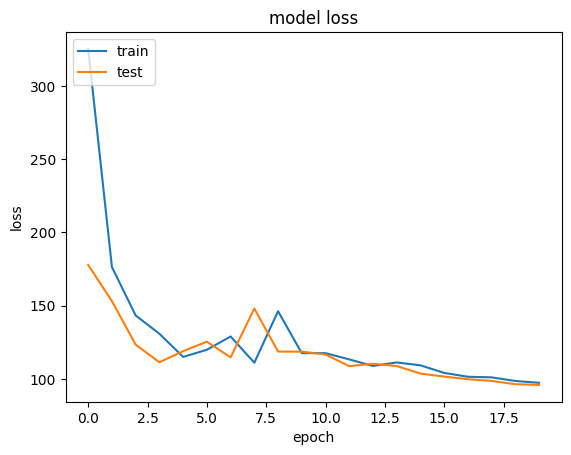

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validat'], loc='upper left')
plt.show()
